In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

df = pd.read_csv('book.log', header=None, names=['TYPE', 'TIME', 'a', 'b', 'c', 'd', 'e', 'f', 'g'])

In [77]:
bbo_df = df[df['TYPE'] == 'ORDER BOOK'][['TYPE', 'TIME', 'a', 'b', 'c', 'd']]
bbo_df.columns = ['TYPE', 'TIME', 'Direction', 'Price', 'Quantity', 'OrderID']

def clean(bids):
    all_bids = []
    for bid in bids: 
        try:
            splitup = bid.split('|')
            # format: (price, quantity, ID)
            bids = [(float(el.split('/')[0]), float(el.split('/')[1]), el.split('/')[2]) for el in splitup[:-1]]
            bids.sort()
            all_bids.append(bids)
        except:
            all_bids.append([(np.nan, np.nan, np.nan)])
    return all_bids
        
bbo_df['OFFERS'] = clean(bbo_df['OFFERS'])
bbo_df['BIDS'] = clean(bbo_df['BIDS'])

trade_df = df[df['TYPE'] == 'TRADE']
trade_df.columns = ['TYPE', 'TIME', 'Ticker', 'Price', 'Quantity', 'Buy?', 'RestingID', 'AggID']
trade_df['Price'] = trade_df['Price'].astype(float)
trade_df['Price'] = trade_df['Price'].astype(float)

C:\Users\George\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\George\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [78]:
bbo_df.tail()

,TYPE,TIME,OFFERS,BIDS
183110,ORDER BOOK,1518432464252817,"[(111.77, 462.0, 26811200145474211), (111.78, ...","[(111.35, 7354.0, 2835669269083342939), (111.3..."
183112,ORDER BOOK,1518432464360612,"[(111.77, 462.0, 26811200145474211), (111.78, ...","[(111.35, 7354.0, 2835669269083342939), (111.3..."
183114,ORDER BOOK,1518432464460525,"[(111.77, 462.0, 26811200145474211), (111.78, ...","[(111.35, 7354.0, 2835669269083342939), (111.3..."
183116,ORDER BOOK,1518432464564252,"[(111.77, 462.0, 26811200145474211), (111.78, ...","[(111.35, 7354.0, 2835669269083342939)]"
183118,ORDER BOOK,1518432464662401,"[(111.38, 19195.0, 4861381554936927802), (111....","[(111.35, 7354.0, 2835669269083342939)]"


In [79]:
trade_df.head()

,TYPE,TIME,Ticker,Price,Quantity,Buy?,RestingID,AggID
31,TRADE,1518339709239599,NaN,99.87,195.0,0.0,14725635598718877035,12789885460822914395
33,TRADE,1518339709283171,NaN,99.87,196.0,0.0,14725635598718877035,14413008875968892004
35,TRADE,1518339709322743,NaN,99.87,48.0,0.0,14725635598718877035,10337768875726675651
37,TRADE,1518339709360115,NaN,99.86,125.0,0.0,6407062462824709134,10337768875726675651
87,TRADE,1518339710840147,NaN,99.84,182.0,0.0,5266392160912295759,15289252224441739692


In [83]:
len(bbo_df), len(trade_df)

(163546, 19573)

In [81]:
## calculate interesting things

bbo_df['BB'] = [bid[-1][0] for bid in bbo_df['BIDS']]
bbo_df['BO'] = [bid[0][0] for bid in bbo_df['OFFERS']]
bbo_df['BB_size'] = [bid[-1][1] for bid in bbo_df['BIDS']]
bbo_df['BO_size'] = [bid[0][1] for bid in bbo_df['OFFERS']]
bbo_df['BB_ID'] = [bid[-1][2] for bid in bbo_df['BIDS']]
bbo_df['BO_ID'] = [bid[0][2] for bid in bbo_df['OFFERS']]

bbo_df['Spread'] = bbo_df['BO'] - bbo_df['BB']
bbo_df['swmid'] = (bbo_df['BB'] * bbo_df['BO_size'] + bbo_df['BO'] * bbo_df['BB_size']) / (bbo_df['BO_size'] + bbo_df['BB_size'])

bbo_df['B_size'] = [sum(el[1] for el in bid) for bid in bbo_df['BIDS']]
bbo_df['O_size'] = [sum(el[1] for el in bid) for bid in bbo_df['OFFERS']]

threshold = 20000
bbo_df['Large_B'] = [sum(el[1]>threshold for el in bid) for bid in bbo_df['BIDS']]
bbo_df['Large_O'] = [sum(el[1]>threshold for el in bid) for bid in bbo_df['OFFERS']]

## calculate Pnls to swmid

def get_swmid(t):
    ## gets swmid at next time >= t
    idx = np.searchsorted(bbo_df['TIME'], t)
    return bbo_df['swmid'].values[idx-1]

deltas = [int(1e9), int(5e8), int(1e8), int(5e7)]
for delta in deltas:
    bbo_df[str(delta)+"_pnl_to_swmid"] = [get_swmid(t+delta)-swmid for t,swmid in 
                                          zip(bbo_df['TIME'], bbo_df['swmid'])] # assumes buying

In [82]:
bbo_df.tail()

,TYPE,TIME,OFFERS,BIDS,BB,BO,Spread,BB_size,BO_size,swmid,BB_ID,BO_ID,B_size,O_size,Large_B,Large_O,1000000000_pnl_to_swmid,500000000_pnl_to_swmid,100000000_pnl_to_swmid,50000000_pnl_to_swmid
183110,ORDER BOOK,1518432464252817,"[(111.77, 462.0, 26811200145474211), (111.78, ...","[(111.35, 7354.0, 2835669269083342939), (111.3...",111.39,111.77,0.38,6247.0,462.0,111.743832,2839028360085209625,26811200145474211,17743.0,107978.0,0,0,-0.385522,-0.385522,-0.385522,-0.385522
183112,ORDER BOOK,1518432464360612,"[(111.77, 462.0, 26811200145474211), (111.78, ...","[(111.35, 7354.0, 2835669269083342939), (111.3...",111.39,111.77,0.38,4142.0,462.0,111.731868,4994981945536978812,26811200145474211,13921.0,107978.0,0,0,-0.373558,-0.373558,-0.373558,-0.373558
183114,ORDER BOOK,1518432464460525,"[(111.77, 462.0, 26811200145474211), (111.78, ...","[(111.35, 7354.0, 2835669269083342939), (111.3...",111.39,111.77,0.38,4142.0,462.0,111.731868,4994981945536978812,26811200145474211,11496.0,107978.0,0,0,-0.373558,-0.373558,-0.373558,-0.373558
183116,ORDER BOOK,1518432464564252,"[(111.77, 462.0, 26811200145474211), (111.78, ...","[(111.35, 7354.0, 2835669269083342939)]",111.35,111.77,0.42,7354.0,462.0,111.745174,2835669269083342939,26811200145474211,7354.0,107978.0,0,0,-0.386864,-0.386864,-0.386864,-0.386864
183118,ORDER BOOK,1518432464662401,"[(111.38, 19195.0, 4861381554936927802), (111....","[(111.35, 7354.0, 2835669269083342939)]",111.35,111.38,0.03,7354.0,19195.0,111.358310,2835669269083342939,4861381554936927802,7354.0,127173.0,0,0,0.000000,0.000000,0.000000,0.000000


## looking at 30k trades a bit closer

In [84]:
niche_df = bbo_df[bbo_df['Large_O'] > 0]
niche_df

,TYPE,TIME,OFFERS,BIDS,BB,BO,Spread,BB_size,BO_size,swmid,BB_ID,BO_ID,B_size,O_size,Large_B,Large_O,1000000000_pnl_to_swmid,500000000_pnl_to_swmid,100000000_pnl_to_swmid,50000000_pnl_to_swmid
111,ORDER BOOK,1518339711716531,"[(100.13, 210.0, 15651555880332587102), (100.1...","[(99.71, 6892.0, 9430880998073698446), (99.72,...",99.85,100.13,0.28,320.0,210.0,100.019057,10674296270034839507,15651555880332587102,52923.0,89603.0,0,1,0.780730,0.128467,-0.331079,-0.268927
113,ORDER BOOK,1518339711804701,"[(100.12, 30000.0, 11567569066771835732), (100...","[(99.71, 6892.0, 9430880998073698446), (99.72,...",99.85,100.12,0.27,320.0,30000.0,99.852850,10674296270034839507,11567569066771835732,52923.0,89603.0,0,1,0.946937,0.294674,-0.164872,-0.102720
114,ORDER BOOK,1518339711847771,"[(100.12, 29771.0, 11567569066771835732), (100...","[(99.71, 6892.0, 9430880998073698446), (99.72,...",99.85,100.12,0.27,320.0,29771.0,99.852871,10674296270034839507,11567569066771835732,52923.0,89374.0,0,1,0.946916,0.294652,-0.164894,-0.102742
117,ORDER BOOK,1518339714284998,"[(100.1, 30000.0, 11533601792378736023), (100....","[(99.71, 6892.0, 9430880998073698446), (99.72,...",99.85,100.10,0.25,320.0,30000.0,99.852639,10674296270034839507,11533601792378736023,52923.0,89603.0,0,1,0.947148,0.313421,-0.150740,-0.102509
118,ORDER BOOK,1518339714393422,"[(100.1, 30000.0, 11533601792378736023), (100....","[(99.71, 6892.0, 9430880998073698446), (99.72,...",99.85,100.10,0.25,320.0,30000.0,99.852639,10674296270034839507,11533601792378736023,57845.0,89603.0,0,1,0.947148,0.313421,-0.150740,-0.102509
119,ORDER BOOK,1518339714450749,"[(100.1, 30000.0, 11533601792378736023), (100....","[(99.71, 6892.0, 9430880998073698446), (99.73,...",99.85,100.10,0.25,320.0,30000.0,99.852639,10674296270034839507,11533601792378736023,50331.0,89603.0,0,1,0.947148,0.313421,-0.150740,-0.102509
120,ORDER BOOK,1518339714501730,"[(100.1, 30000.0, 11533601792378736023), (100....","[(99.73, 3293.0, 8291273604027682477), (99.73,...",99.85,100.10,0.25,320.0,30000.0,99.852639,10674296270034839507,11533601792378736023,43439.0,89603.0,0,1,0.947148,0.313421,-0.150740,-0.102509
121,ORDER BOOK,1518339714591503,"[(100.1, 30000.0, 11533601792378736023), (100....","[(99.73, 3293.0, 8291273604027682477), (99.73,...",99.85,100.10,0.25,320.0,30000.0,99.852639,10674296270034839507,11533601792378736023,46874.0,89603.0,0,1,0.947148,0.313421,-0.150740,-0.102509
122,ORDER BOOK,1518339716081043,"[(100.1, 30000.0, 11533601792378736023), (100....","[(99.73, 3293.0, 8291273604027682477), (99.73,...",99.85,100.10,0.25,320.0,30000.0,99.852639,10674296270034839507,11533601792378736023,47845.0,89603.0,0,1,0.947148,0.313110,-0.150740,-0.102509
123,ORDER BOOK,1518339716183454,"[(100.1, 30000.0, 11533601792378736023), (100....","[(99.73, 3293.0, 8291273604027682477), (99.73,...",99.85,100.10,0.25,320.0,30000.0,99.852639,10674296270034839507,11533601792378736023,47845.0,94007.0,0,1,0.947148,0.313110,-0.150740,-0.102509


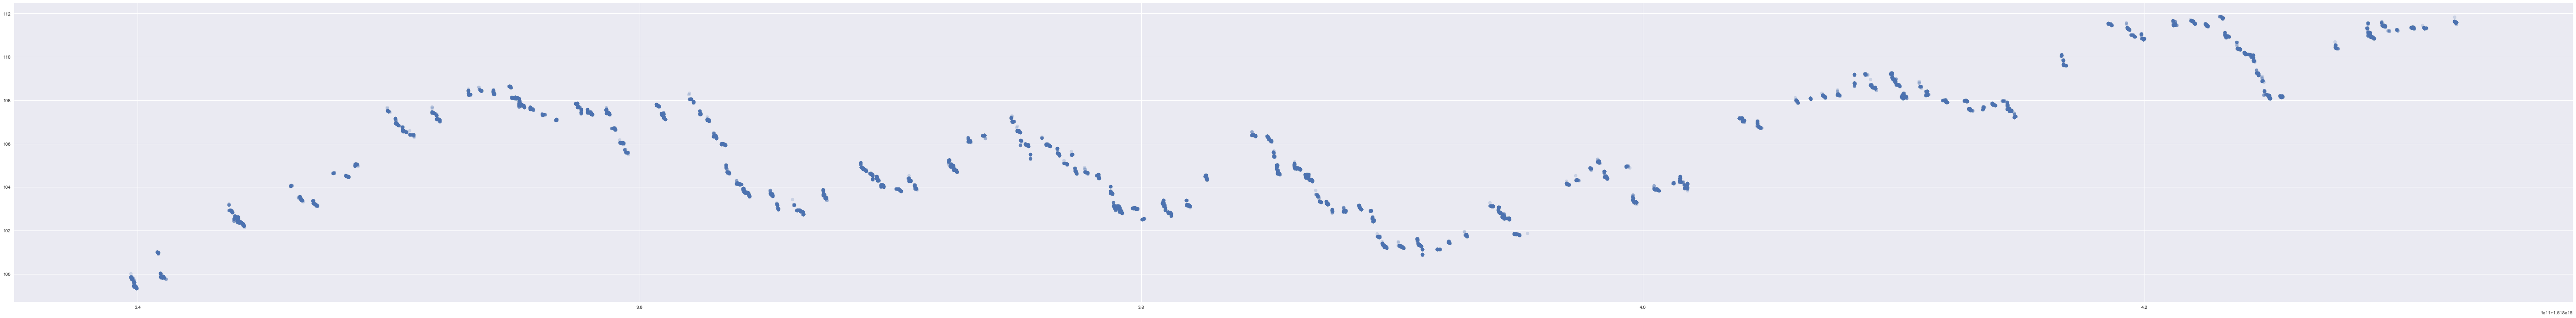

In [85]:
plt.figure(figsize=(100,12))
plt.scatter(niche_df['TIME'], niche_df['swmid'], label='swmid', alpha=0.2)
plt.show()

In [91]:
bbo_df['has30k_bid'] = [sum(el[1]==30000 for el in bid) for bid in bbo_df['BIDS']]
bbo_df['has30k_offer'] = [sum(el[1]==30000 for el in bid) for bid in bbo_df['OFFERS']]
niche_30k_df = bbo_df[bbo_df['has30k_bid'] + bbo_df['has30k_offer'] > 0]

def get_30k_id(bids):
    result = [None] * len(bids)
    for i, bid in enumerate(bids):
        for el in bid:
            if el[1] == 30000:
                result[i] = el[2]
    return result

niche_30k_df['30k_bid_id'] = get_30k_id(niche_30k_df['BIDS'])
niche_30k_df['30k_offer_id'] = get_30k_id(niche_30k_df['OFFERS'])
            
niche_30k_df

C:\Users\George\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\George\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,TYPE,TIME,OFFERS,BIDS,BB,BO,Spread,BB_size,BO_size,swmid,...,Large_B,Large_O,1000000000_pnl_to_swmid,500000000_pnl_to_swmid,100000000_pnl_to_swmid,50000000_pnl_to_swmid,has30k_bid,has30k_offer,30k_bid_id,30k_offer_id
111,ORDER BOOK,1518339711716531,"[(100.13, 210.0, 15651555880332587102), (100.1...","[(99.71, 6892.0, 9430880998073698446), (99.72,...",99.85,100.13,0.28,320.0,210.0,100.019057,...,0,1,0.780730,0.128467,-0.331079,-0.268927,0,1,None,14153756629860496904
113,ORDER BOOK,1518339711804701,"[(100.12, 30000.0, 11567569066771835732), (100...","[(99.71, 6892.0, 9430880998073698446), (99.72,...",99.85,100.12,0.27,320.0,30000.0,99.852850,...,0,1,0.946937,0.294674,-0.164872,-0.102720,0,1,None,11567569066771835732
117,ORDER BOOK,1518339714284998,"[(100.1, 30000.0, 11533601792378736023), (100....","[(99.71, 6892.0, 9430880998073698446), (99.72,...",99.85,100.10,0.25,320.0,30000.0,99.852639,...,0,1,0.947148,0.313421,-0.150740,-0.102509,0,1,None,11533601792378736023
118,ORDER BOOK,1518339714393422,"[(100.1, 30000.0, 11533601792378736023), (100....","[(99.71, 6892.0, 9430880998073698446), (99.72,...",99.85,100.10,0.25,320.0,30000.0,99.852639,...,0,1,0.947148,0.313421,-0.150740,-0.102509,0,1,None,11533601792378736023
119,ORDER BOOK,1518339714450749,"[(100.1, 30000.0, 11533601792378736023), (100....","[(99.71, 6892.0, 9430880998073698446), (99.73,...",99.85,100.10,0.25,320.0,30000.0,99.852639,...,0,1,0.947148,0.313421,-0.150740,-0.102509,0,1,None,11533601792378736023
120,ORDER BOOK,1518339714501730,"[(100.1, 30000.0, 11533601792378736023), (100....","[(99.73, 3293.0, 8291273604027682477), (99.73,...",99.85,100.10,0.25,320.0,30000.0,99.852639,...,0,1,0.947148,0.313421,-0.150740,-0.102509,0,1,None,11533601792378736023
121,ORDER BOOK,1518339714591503,"[(100.1, 30000.0, 11533601792378736023), (100....","[(99.73, 3293.0, 8291273604027682477), (99.73,...",99.85,100.10,0.25,320.0,30000.0,99.852639,...,0,1,0.947148,0.313421,-0.150740,-0.102509,0,1,None,11533601792378736023
122,ORDER BOOK,1518339716081043,"[(100.1, 30000.0, 11533601792378736023), (100....","[(99.73, 3293.0, 8291273604027682477), (99.73,...",99.85,100.10,0.25,320.0,30000.0,99.852639,...,0,1,0.947148,0.313110,-0.150740,-0.102509,0,1,None,11533601792378736023
123,ORDER BOOK,1518339716183454,"[(100.1, 30000.0, 11533601792378736023), (100....","[(99.73, 3293.0, 8291273604027682477), (99.73,...",99.85,100.10,0.25,320.0,30000.0,99.852639,...,0,1,0.947148,0.313110,-0.150740,-0.102509,0,1,None,11533601792378736023
124,ORDER BOOK,1518339716284897,"[(100.1, 30000.0, 11533601792378736023), (100....","[(99.73, 3293.0, 8291273604027682477), (99.73,...",99.85,100.10,0.25,320.0,30000.0,99.852639,...,0,1,0.947148,0.324832,-0.150740,-0.102509,0,1,None,11533601792378736023


In [97]:
len(niche_30k_df['30k_offer_id'].unique())

900

In [107]:
bbo_df['BIDS'].apply(pd.Series)


,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,"(99.73, 9496.0, 13631257294748939768)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"(99.73, 9496.0, 13631257294748939768)","(99.75, 9735.0, 1786279016451471409)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"(99.73, 9496.0, 13631257294748939768)","(99.75, 9735.0, 1786279016451471409)","(99.77, 7051.0, 13636593784223591013)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"(99.73, 9496.0, 13631257294748939768)","(99.75, 9735.0, 1786279016451471409)","(99.77, 7051.0, 13636593784223591013)","(99.79, 3712.0, 14054626610365953807)",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"(99.73, 9496.0, 13631257294748939768)","(99.75, 9735.0, 1786279016451471409)","(99.77, 7051.0, 13636593784223591013)","(99.78, 4068.0, 9795249260207111828)","(99.79, 3712.0, 14054626610365953807)",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"(99.73, 9496.0, 13631257294748939768)","(99.75, 9735.0, 1786279016451471409)","(99.77, 7051.0, 13636593784223591013)","(99.78, 4068.0, 9795249260207111828)","(99.79, 3712.0, 14054626610365953807)","(99.82, 1675.0, 11615456531575304825)",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,"(99.73, 9496.0, 13631257294748939768)","(99.75, 9735.0, 1786279016451471409)","(99.77, 7051.0, 13636593784223591013)","(99.78, 4068.0, 9795249260207111828)","(99.79, 3712.0, 14054626610365953807)","(99.82, 1675.0, 11615456531575304825)","(99.83, 377.0, 9978036908900541286)",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,"(99.73, 9496.0, 13631257294748939768)","(99.75, 9735.0, 1786279016451471409)","(99.77, 7051.0, 13636593784223591013)","(99.78, 4068.0, 9795249260207111828)","(99.79, 3712.0, 14054626610365953807)","(99.82, 1675.0, 11615456531575304825)","(99.83, 377.0, 9978036908900541286)","(99.84, 389.0, 5266392160912295759)",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,"(99.73, 9496.0, 13631257294748939768)","(99.75, 9735.0, 1786279016451471409)","(99.77, 7051.0, 13636593784223591013)","(99.78, 4068.0, 9795249260207111828)","(99.79, 3712.0, 14054626610365953807)","(99.8, 4247.0, 6533851563387072327)","(99.82, 1675.0, 11615456531575304825)","(99.83, 377.0, 9978036908900541286)","(99.84, 389.0, 5266392160912295759)",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,"(99.73, 9496.0, 13631257294748939768)","(99.75, 9735.0, 1786279016451471409)","(99.77, 7051.0, 13636593784223591013)","(99.78, 4068.0, 9795249260207111828)","(99.79, 3712.0, 14054626610365953807)","(99.8, 4247.0, 6533851563387072327)","(99.82, 1675.0, 11615456531575304825)","(99.83, 377.0, 9978036908900541286)","(99.84, 389.0, 5266392160912295759)","(99.85, 684.0, 8906887272711196217)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


C:\Users\George\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


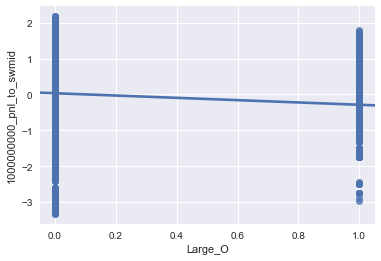

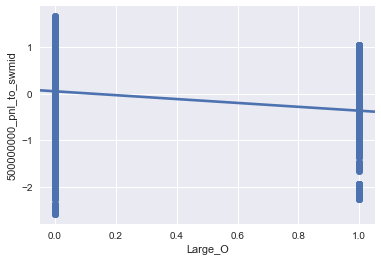

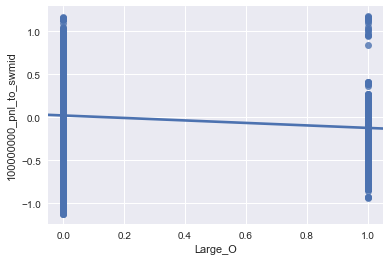

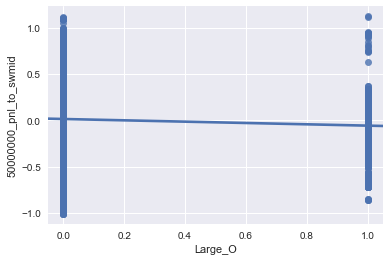

In [61]:
threshold = 15000
bbo_df['Large_B'] = [sum(el[1]>threshold for el in bid) for bid in bbo_df['BIDS']]
bbo_df['Large_O'] = [sum(el[1]>threshold for el in bid) for bid in bbo_df['OFFERS']]

for delta in deltas:
    sns.regplot(bbo_df['Large_O'], bbo_df[str(delta)+"_pnl_to_swmid"])
    plt.show()

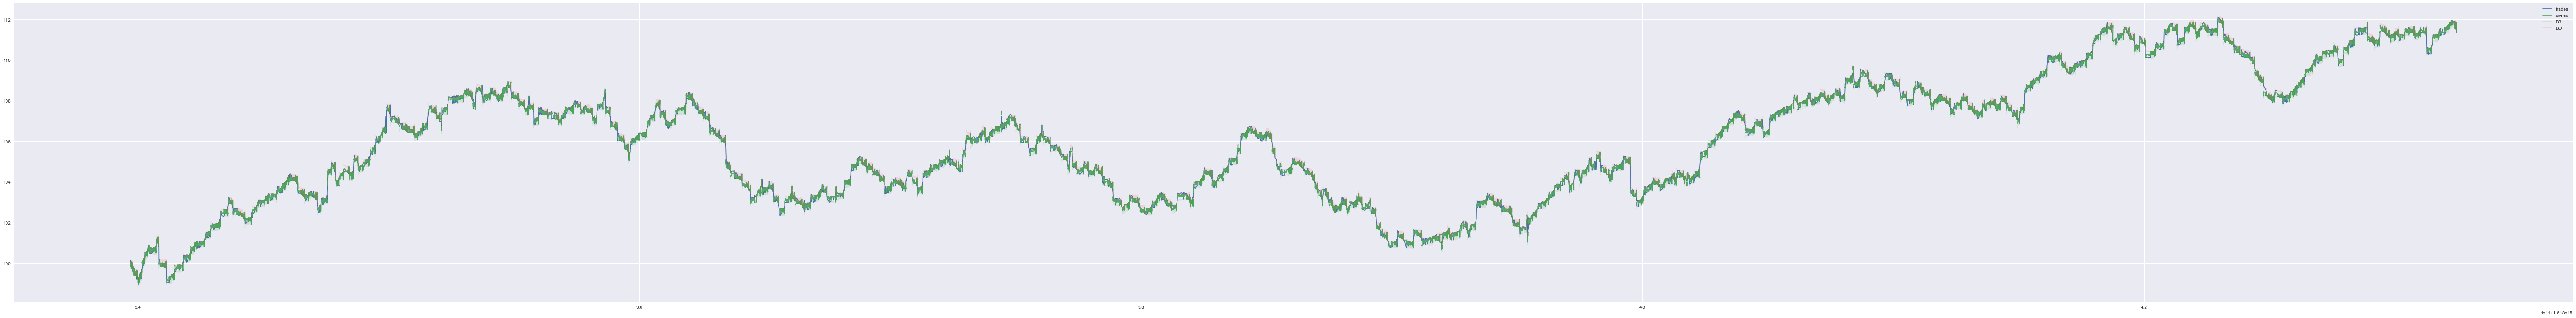

In [98]:
plt.figure(figsize=(100,12))
plt.plot(trade_df['TIME'], trade_df['Price'], label='trades')
plt.plot(bbo_df['TIME'], bbo_df['swmid'], label='swmid')
plt.plot(bbo_df['TIME'], bbo_df['BB'], label='BB', alpha=0.1, c='g')
plt.plot(bbo_df['TIME'], bbo_df['BO'], label='BO', alpha=0.1, c='r')
plt.legend()
plt.show()

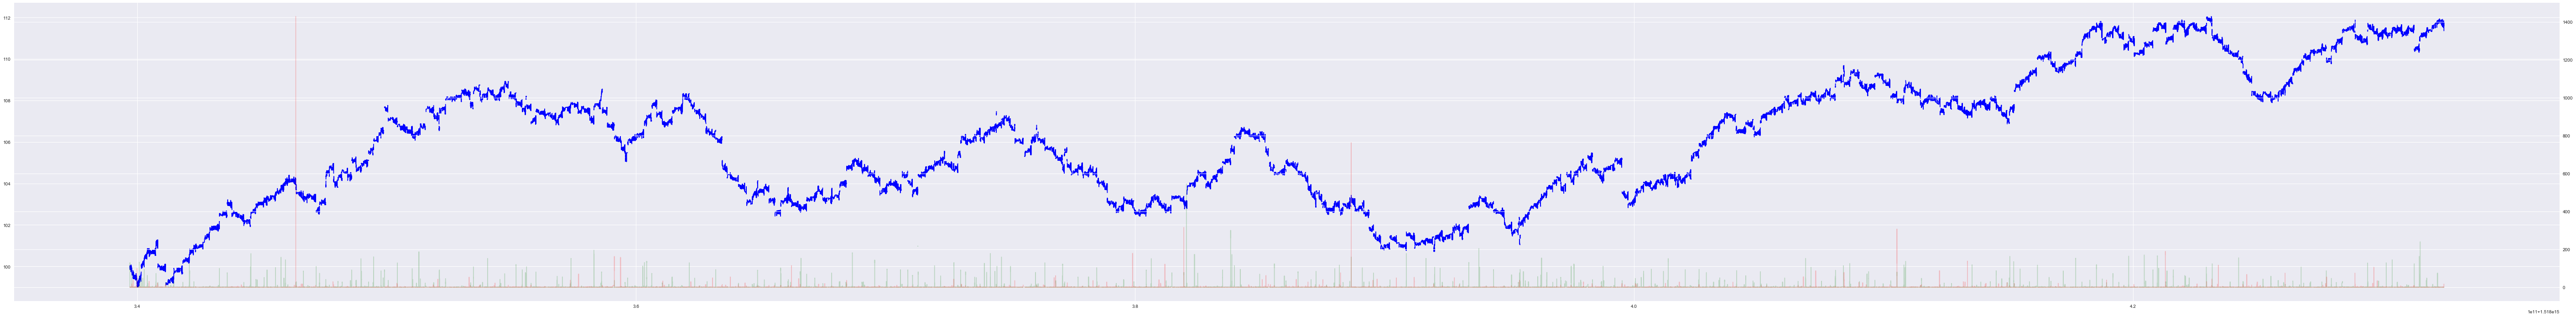

In [99]:
plt.figure(figsize=(100,12))
plt.plot(bbo_df['TIME'], bbo_df['swmid'], label='swmid', c='b')
ax2 = plt.twinx()
ax2.plot(bbo_df['TIME'], bbo_df['B_size'] / bbo_df['O_size'], label='bidsize', c='g', alpha=0.2)
ax2.plot(bbo_df['TIME'], bbo_df['O_size'] / bbo_df['B_size'], label='bidsize', c='r', alpha=0.2)
plt.show()

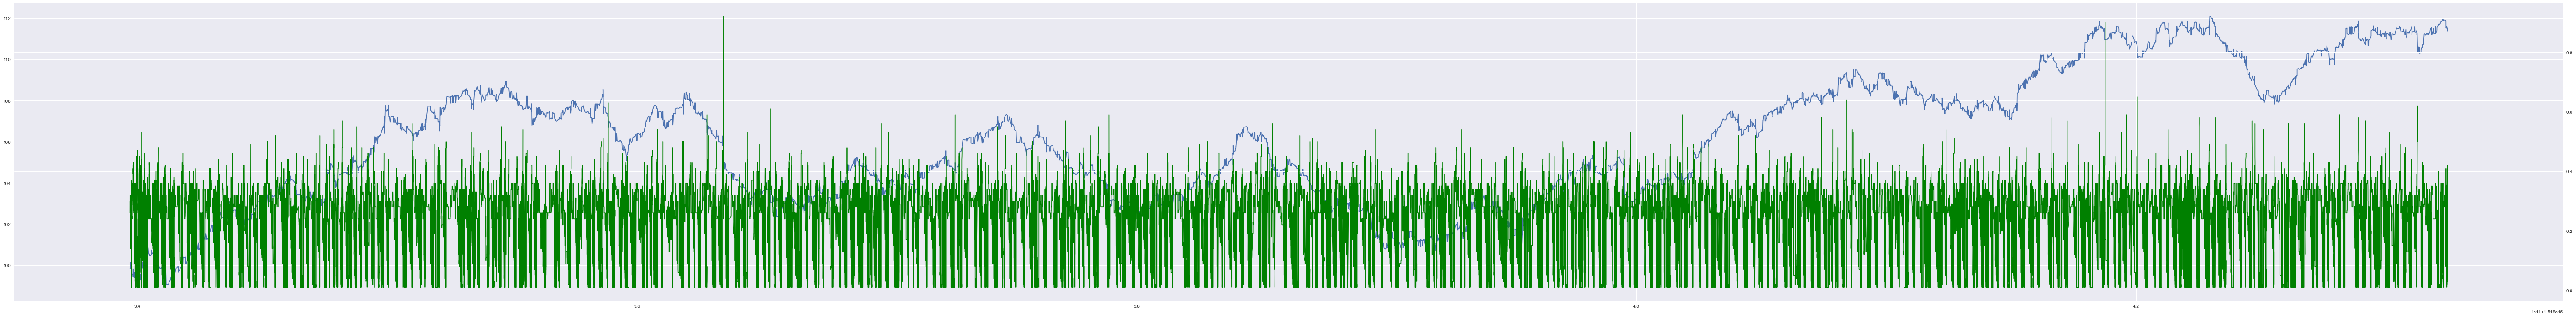

In [100]:
plt.figure(figsize=(100,12))
plt.plot(trade_df['TIME'], trade_df['Price'], label='trades')
ax2 = plt.twinx()
ax2.plot(bbo_df['TIME'], bbo_df['Spread'], label='Spread', c='g')
plt.show()

C:\Users\George\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


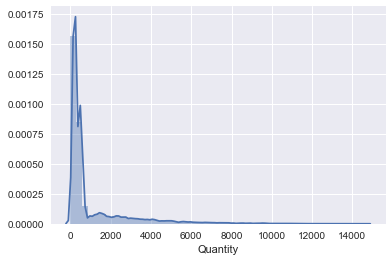

In [101]:
sns.distplot(trade_df['Quantity'])

In [ ]:
plt.scatter()